In [111]:
import pandas as pd
import numpy as np

## Importing and Preparing Data

In [112]:
data = pd.read_csv("data.csv")

def sentimentNumeric(sentiment):
    if sentiment=="positive":
        return 1
    elif sentiment=="neutral":
        return 0
    elif sentiment=="negative":
        return -1

data["sentiment numeric"] = [sentimentNumeric(sentiment) for sentiment in data["Sentiment"]]

## Splitting Data into Training and Testing Sets

In [113]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(data, test_size=0.3, random_state=42)

x_train, x_test, y_train, y_test = training["Sentence"], test["Sentence"], training["sentiment numeric"], test["sentiment numeric"]

## Vectorization of Text

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
tv = CountVectorizer()

x_train_v = tv.fit_transform(x_train)
x_test_v = tv.transform(x_test)

## Classification

### Support Vector Machine

In [115]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train_v, y_train)
prediction = clf.predict(x_test_v)

from sklearn.metrics import accuracy_score
svm_score = accuracy_score(y_test, prediction)

### Decision Tree

In [116]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train_v, y_train)
decisiontree_score = dtc.score(x_test_v, y_test)

### Random Forest Classifier

In [117]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train_v, y_train)
randomforest_score = rfc.score(x_test_v, y_test)

### Multinomial Naive Bayes

In [118]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()
gnb.fit(x_train_v.toarray(), y_train)
multinomialNB_score = gnb.score(x_test_v.toarray(), y_test)

### Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=300)
lr.fit(x_train_v, y_train)
logisticregression_score = lr.score(x_test_v, y_test)

### Multi-Layer Perceptron

In [120]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(activation="logistic", solver="lbfgs", max_iter=400)
mlp.fit(x_train_v, y_train)
mLP_score = mlp.score(x_test_v, y_test)

### Stacking Classifiers

#### Layer: 3 Classifiers (
####    Stacked Classifiers ( Final Classifier: Logistic Regression
####        1: (Random Forest Classifier, Multinomial Naive Bayes, Multi-Layer Perceptron)
####        2: (Multi-Layer Perceptron, Logistic Regression, Support Vector Machine)
####        3: (Multinomial Naive Bayes, Multi-Layer Perceptron, Logistic Regression)
####    )
#### )

In [121]:
from sklearn.ensemble import StackingClassifier

estim1 = [('rfc', RandomForestClassifier(random_state=42)), ('gnb', MultinomialNB()), ('mlp', MLPClassifier(activation="logistic", solver="lbfgs", max_iter=400))]
estim2 = [('mlp', MLPClassifier(activation="logistic", solver="lbfgs", max_iter=400)), ('lr', LogisticRegression(max_iter=300)), ('clf', svm.SVC())]
estim3 = [('gnb', MultinomialNB()), ('mlp', MLPClassifier(activation="logistic", solver="lbfgs", max_iter=400)), ('lr', LogisticRegression(max_iter=300))]

stc1 = StackingClassifier(estimators=estim1, final_estimator=lr)
stc2 = StackingClassifier(estimators=estim2, final_estimator=lr)
stc3 = StackingClassifier(estimators=estim3, final_estimator=lr)

estim = [('e1', stc1), ('e2', stc2), ('e3', stc3)]
stc = StackingClassifier(estimators=estim, final_estimator=lr)

fit1 = stc1.fit(x_train_v, y_train)
fit2 = stc2.fit(x_train_v, y_train)
fit3 = stc3.fit(x_train_v, y_train)

predi1 = fit1.predict(x_test_v)
predi2 = fit2.predict(x_test_v)
predi3 = fit3.predict(x_test_v)

def roundOff(num):
    if num>=0:
        if int(num)==int(num+0.5):
            return int(num)
        else:
            return int(num)+1
    else:
        if int(num)==int(num-0.5):
            return int(num)
        else:
            return int(num)-1

        
predi = [roundOff((predi1[i]+predi2[i]+predi3[i])/3) for i in range(len(predi1))]

stacked_score = accuracy_score(y_test, predi)

### Comparing Accuracy of Classifiers

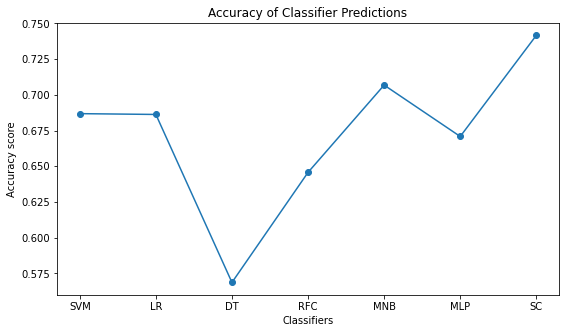

In [129]:
import matplotlib.pyplot as plt

score_plot = {
    'SVM': svm_score,
    'LR': logisticregression_score,
    'DT': decisiontree_score,
    'RFC': randomforest_score,
    'MNB': multinomialNB_score,
    'MLP': mLP_score,
    'SC': stacked_score
}

fig = plt.figure(figsize=(9, 5))
plt.plot(list(score_plot.keys()), list(score_plot.values()), marker='o')
plt.xlabel("Classifiers")
plt.ylabel("Accuracy score")
plt.title("Accuracy of Classifier Predictions")
plt.show()

### Implementing Stacked Classifier

In [127]:
class ClassifyStatement():
    def __init__(self, sentence):
        arr = [sentence]
        self.vectorText = tv.transform(arr)
    
    def __convertToSentiment(self, num):
        if num==-1:
            return "NEGATIVE"
        elif num==0:
            return "NEUTRAL"
        elif num==1:
            return "POSITIVE"
    
    def __roundOff(self, num):
        if num>=0:
            if int(num)==int(num+0.5):
                return int(num)
            else:
                return int(num)+1
        else:
            if int(num)==int(num-0.5):
                return int(num)
            else:
                return int(num)-1
    
    def predictClass(self):
        predi1 = fit1.predict(self.vectorText)
        predi2 = fit2.predict(self.vectorText)
        predi3 = fit3.predict(self.vectorText)
        
        predi = self.__roundOff((predi1[0]+predi2[0]+predi3[0])/3)
        print(self.__convertToSentiment(predi))
        return True


user_sentence = input("Enter Financial Statement: ")
obj = ClassifyStatement(user_sentence)
obj.predictClass()

Enter Financial Statement: Lithuanian beer makers sold 256.88 million liters of beer in 2005 , a rise of 4.5 per cent from the year-earlier figure of 245.92 million liters .
POSITIVE


True